# Part 1 - Create Amazon Review/FDA Recall DataFrame

In [1]:
import pandas
import os
wd = os.getcwd()

## Read in Review Files and create a pandas dataframe (code borrowed from Julian McAuley website) ##
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

food_review = getDF(os.path.join(wd,"..","data/raw/reviews_Grocery_and_Gourmet_Food.json.gz"))

In [2]:
##Call in data that includes ASINs from original press release data
recall_data = pandas.read_csv(os.path.join(wd,"..","data/processed/asin_intersection_full.csv"),
                              encoding='ISO-8859-1')
full_df = pd.merge(food_review, recall_data, how = "left", on = ["asin"])

In [3]:
##Format Dates to match
full_df['unixReviewTime'] = pandas.to_datetime(full_df['unixReviewTime'], unit='s').dt.date
full_df['initiation_date'] = pandas.to_datetime(full_df['initiation_date'], unit='s').dt.date

In [4]:
##Add Date bounderies
full_df['initiation_date_plus1Y'] = pandas.to_datetime(full_df['initiation_date'] + pandas.DateOffset(years=1)).dt.date
full_df['initiation_date_minus1Y'] = pandas.to_datetime(full_df['initiation_date'] - pandas.DateOffset(years=1)).dt.date

full_df['initiation_date_plus6M'] = pandas.to_datetime(full_df['initiation_date'] + pandas.DateOffset(months=6)).dt.date
full_df['initiation_date_minus6M'] = pandas.to_datetime(full_df['initiation_date'] - pandas.DateOffset(months=6)).dt.date

In [5]:
##Define recall in 4 ways:
#  1) to have recall date and review be within a year of the recall
#  2) to have a recall date and review be within 6 months of the recall
#  3) to have a recall date and the review be one year before the recall
#  4) to have a recall date and the review be 6 months before the recall

full_df['recalled_1y'] = (((full_df['unixReviewTime'] < full_df['initiation_date_plus1Y']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus1Y']) == True)).astype('int')

full_df['recalled_6m'] = (((full_df['unixReviewTime'] < full_df['initiation_date_plus6M']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus6M']) == True)).astype('int')

full_df['recalled_1yb4'] = (((full_df['unixReviewTime'] < full_df['initiation_date']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus1Y']) == True)).astype('int')

full_df['recalled_6mb4'] = (((full_df['unixReviewTime'] < full_df['initiation_date']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus6M']) == True)).astype('int')

In [6]:
##Check number of recalled reviews for each definition of 'Recall'
print("Review +/- 1 Year from recall: %d" % full_df['recalled_1y'].sum())
print("Review 1 year before recall: %d" %full_df['recalled_1yb4'].sum())
print("Review +/- 6 Months from recall: %d" %full_df['recalled_6m'].sum())
print("Review 6 months before recall: %d" %full_df['recalled_6mb4'].sum())

Review +/- 1 Year from recall: 1285
Review 1 year before recall: 790
Review +/- 6 Months from recall: 547
Review 6 months before recall: 335


## Part 2 - Subset and Clean Text Data

In [7]:
##Subset data - create a random sample of 0.5% of the non-recalled reviews, and all recalled products
full_df_recalled = full_df[full_df.recalled_1y == 1]
full_df_nonrecalled = full_df[full_df.recalled_1y == 0]

from sklearn.cross_validation import train_test_split
X_testRecall, X_trainRecall, Y_testRecall, Y_trainRecall = train_test_split(full_df_recalled['reviewText'], full_df_recalled['recalled_1y'], \
                                                    test_size=0.999, random_state=123)

X_testNoRecall, X_trainNoRecall, Y_testNoRecall, Y_trainNoRecall = train_test_split(full_df_nonrecalled['reviewText'], full_df_nonrecalled['recalled_1y'], \
                                                    test_size=0.005, random_state=123)



##Combined to have subsets with 1/2 of the recall data each
Xtrain = pd.concat([X_trainRecall, X_trainNoRecall], axis=0)
Xtrain = pd.DataFrame(Xtrain, columns=['reviewText'], dtype=str)
Ytrain = pd.concat([Y_trainRecall, Y_trainNoRecall], axis=0)

In [8]:
##Add all other "Recall" Definitions to the Ytrain dataset and create a final subset
Ytrain = pd.merge(pd.DataFrame(Ytrain), pd.DataFrame(full_df.recalled_1yb4), left_index=True, right_index=True)
Ytrain = pd.merge(Ytrain, pd.DataFrame(full_df.recalled_6m), left_index=True, right_index=True)
Ytrain = pd.merge(Ytrain, pd.DataFrame(full_df.recalled_6mb4), left_index=True, right_index=True)
Ytrain = pd.merge(Ytrain, pd.DataFrame(full_df.asin), left_index=True, right_index=True)
Subset = pd.merge(Xtrain, Ytrain, left_index=True, right_index=True)

In [9]:
##Tokenize review text for each review
import numpy as np
from nltk import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

Subset['reviewText'] = Subset['reviewText'].str.replace("'", "")
Subset['reviewText'] = Subset['reviewText'].str.replace('[^a-zA-Z\s]',' ')
tokens_I = [word_tokenize(review) for review in Subset['reviewText']]

In [10]:
##Separate strings with multiple uppercase characters (e.g., gCholesterol, VeronaStarbucks). This should (hopefully)
## take care of situations where the reviews included returns that were not treated as spaces in the raw text file
import re
def split_uppercase(tokens):
    tokens_II = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            split = re.sub(r'([A-Z][a-z])', r' \1', word)
            tokens_II[n].append(split)
    return tokens_II

tokens_II = split_uppercase(tokens_I)

In [11]:
##Make all text lower case
def make_lowercase(tokens):
    tokens_final = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            lowercase_word = word.lower()
            tokens_final[n].append(lowercase_word)
    return tokens_final

tokens = make_lowercase(tokens_II)

In [12]:
##Remove stopwords and stem
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def stem_tokens(tokens):
    stemmed_token = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            if word not in stopwords:
                stem = st.stem(word)
                stemmed_token[n].append(stem)
    return stemmed_token
        
stemmed = stem_tokens(tokens)

In [13]:
##Manipulate stemmed text to be string instead of list (needed for count vectorizer)
def make_string(text):
    final_review_text = []
    for review in text:
        for word in review:
            n = review.index(word)
            if n == 0:
                string = review[n]
            else:
                string = string + " " + review[n]
        final_review_text.append(string)
    return final_review_text

final_text = make_string(stemmed)

## Part 3 - Create Document Term Matrix

In [15]:
##Count Vectorizer Matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 1)) ##Removed stopwords before stemming so don't apply here
text_matrix = vectorizer.fit_transform(final_text)

## Part 4 - Logistic, Ridge, SVM accuracy metrics

In [17]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C=1  ##Note if C is too small percision/recall is zero
alpha = 1/C
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1'),
               'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2'),
               'Linear SVC': svm.SVC(kernel='linear', C=C, probability=True,
                                 random_state=0),
               'Ridge': RidgeClassifier(alpha=alpha)}

recall_defs = {'Review +/- 1 Year from recall': 'recalled_1y',
               'Review 1 year before recall' : 'recalled_1yb4', 
               'Review +/- 6 Months from recall' : 'recalled_6m', 
               'Review 6 months before recall' : 'recalled_6mb4'}


for index, (recall_descrip, recall_def) in enumerate(recall_defs.items()):
    target = np.array(Subset[recall_def])
    X_test, X_train, Y_test, Y_train = train_test_split(text_matrix, target, test_size=0.5, random_state=123)
    print("%s:" % recall_descrip)
    print("------------------------------------------------------")
    for index, (name, classifier) in enumerate(classifiers.items()):
        classifier.fit(X_train, Y_train)
        Y_pred = classifier.predict(X_test)
        print("%s:" % name)
        print("\tAccuracy: %1.3f" % accuracy_score(Y_test, Y_pred))
        print("\tPrecision: %1.3f" % precision_score(Y_test, Y_pred))
        print("\tRecall: %1.3f" % recall_score(Y_test, Y_pred))
        print("\tF1: %1.3f\n" % f1_score(Y_test, Y_pred))

Review 1 year before recall:
------------------------------------------------------
L2 logistic (OvR):
	Accuracy: 0.888
	Precision: 0.451
	Recall: 0.210
	F1: 0.287

Linear SVC:
	Accuracy: 0.860
	Precision: 0.334
	Recall: 0.319
	F1: 0.326

Ridge:
	Accuracy: 0.881
	Precision: 0.378
	Recall: 0.184
	F1: 0.247

L1 logistic:
	Accuracy: 0.887
	Precision: 0.438
	Recall: 0.203
	F1: 0.277

Review +/- 6 Months from recall:
------------------------------------------------------
L2 logistic (OvR):
	Accuracy: 0.920
	Precision: 0.378
	Recall: 0.129
	F1: 0.193

Linear SVC:
	Accuracy: 0.896
	Precision: 0.258
	Recall: 0.220
	F1: 0.238

Ridge:
	Accuracy: 0.919
	Precision: 0.364
	Recall: 0.126
	F1: 0.187

L1 logistic:
	Accuracy: 0.920
	Precision: 0.384
	Recall: 0.133
	F1: 0.197

Review 6 months before recall:
------------------------------------------------------
L2 logistic (OvR):
	Accuracy: 0.948
	Precision: 0.233
	Recall: 0.056
	F1: 0.091

Linear SVC:
	Accuracy: 0.923
	Precision: 0.120
	Recall: 0.107
	

## Part 5 - Key Words and Performance of Linear SVM

In [20]:
##Cross validation with test/train samples that have different products to see if model is product specific
from sklearn.cross_validation import LabelKFold

model = svm.SVC(kernel='linear', C=C, probability=True, random_state=0)
target = np.array(Subset.recalled_1y)

term_names = vectorizer.get_feature_names()
term_names = pd.DataFrame(term_names, columns=['Term'])

labels = np.array(Subset.asin)
lkf_1 = LabelKFold(labels, n_folds=20)
recalled_asins = Subset[(Subset.recalled_1y == 1)].asin.unique()


for index, (test, train) in enumerate(lkf_1):
    results = model.fit(text_matrix[train], target[train])
    Y_pred = model.predict(text_matrix[test])
    
    results_coef_array = np.transpose(results.coef_).todense()
    results_df_coef = pd.DataFrame(results_coef_array, columns=['Coef'])
    results_df_coef = pd.concat([term_names, results_df_coef], axis = 1)
    results_df_coef = results_df_coef.sort_values(by='Coef', ascending=False)
    results_df_coef = results_df_coef[results_df_coef.Coef > 0]
    
    print("CV #%d Train Set Stats" % (index+1))
    print("  Size of Train Set: %d" % len(target[train]))
    print("  Unique products in Train Set: %d" % len(np.unique(labels[train])))
    print("  Unique recalled products in Train Set: %d" % len(pd.merge(pd.DataFrame(recalled_asins, columns=['asin']), \
                                                                       pd.DataFrame(np.unique(labels[train]), columns=['asin']), \
                                                                        how = 'inner', on = ['asin'])))
    print("  Recalls in Train Set: %d" % target[train].sum())

    print(' ')
    print("CV #%d Test Set Stats" % (index+1))   
    print("  Size of Test Set: %d" % len(target[test]))
    print("  Unique products in Test Set: %d" % len(np.unique(labels[test])))
    print("  Unique recalled products in Test Set: %d" % len(pd.merge(pd.DataFrame(recalled_asins, columns=['asin']), \
                                                                       pd.DataFrame(np.unique(labels[test]), columns=['asin']), \
                                                                        how = 'inner', on = ['asin'])))
    print("  Predicted Recalls in Test Set: %d" % Y_pred.sum())
    print("  Actual Recalls in Test Set: %d" % target[test].sum())
    print(' ')
    print("CV #%d Performance" % (index+1))
    print("  Accuracy: %1.3f" % accuracy_score(target[test], Y_pred))
    print("  Precision: %1.3f" % precision_score(target[test], Y_pred))
    print("  Recall: %1.3f" % recall_score(target[test], Y_pred))
    print("  F1: %1.3f\n" % f1_score(target[test], Y_pred))
    print(' ')
    print("Top 25 words predictive words")
    print(results_df_coef.head(n=25))
    print(' ')

CV #1 Train Set Stats
  Size of Train Set: 389
  Unique products in Train Set: 224
  Unique recalled products in Train Set: 4
  Recalls in Train Set: 166
 
CV #1 Test Set Stats
  Size of Test Set: 7375
  Unique products in Test Set: 5062
  Unique recalled products in Test Set: 115
  Predicted Recalls in Test Set: 1064
  Actual Recalls in Test Set: 1118
 
CV #1 Performance
  Accuracy: 0.754
  Precision: 0.174
  Recall: 0.165
  F1: 0.170

 
Top 25 words predictive words
            Term      Coef
6986       plain  0.643978
1832     coconut  0.609174
4773        item  0.556434
9499       thumb  0.486011
4564          in  0.484629
6121         nat  0.477798
3498        food  0.469390
4597     individ  0.428531
3108       evalu  0.411243
9805         two  0.400804
10661       zico  0.390002
10269        wat  0.388018
10497    workout  0.342535
183    albersons  0.340851
3927        grab  0.331430
6493         opt  0.319183
10313        wel  0.311827
6462          on  0.302978
4133        ha

In [23]:
##Use Linear SVM regression for classification and identification of key words since it has the highest/precision/recall
results = model.fit(text_matrix, target)
results_coef_array = np.transpose(results.coef_).todense()
results_df_coef = pd.DataFrame(results_coef_array, columns=['Coef'])
results_df_coef = pd.concat([term_names, results_df_coef], axis = 1)
results_df_coef = results_df_coef.sort_values(by='Coef', ascending=False)
pd.set_option('max_rows', 4000)
results_df_coef[results_df_coef.Coef > 0]

,Term,Coef
3804,gingerbread,1.697815
4921,justins,1.639414
6709,paprik,1.629455
7407,quinoa,1.571956
3951,granddaught,1.525153
3241,fajita,1.496793
288,amino,1.482580
7504,recal,1.444783
10264,wash,1.374378
4066,guav,1.362638


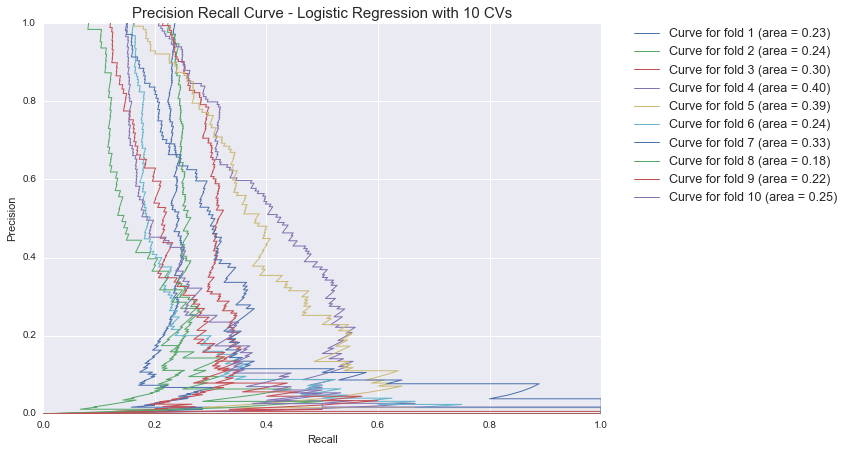

In [24]:
##Percision Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
from sklearn.cross_validation import LabelKFold
import matplotlib.pyplot as plt
%matplotlib inline

labels = np.array(Subset.asin)
lkf = LabelKFold(labels, n_folds=10)
lr = LogisticRegression(C=C, penalty='l2')

plt.figure(figsize=(10,7))

for i, (train, test) in enumerate(lkf):
    y_score = lr.fit(text_matrix[train], target[train]).decision_function(text_matrix[test])
    precision, recall, _ = precision_recall_curve(target[test], y_score)
    average_precision = average_precision_score(target[test], y_score)
    plt.plot(precision, recall, lw=1, label='Curve for fold %d (area = %0.2f)' % (i+1, average_precision))
    
sns.set(style="darkgrid", color_codes=True, font_scale=1.25, palette='bright')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - Logistic Regression with 10 CVs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Part 6 - Evaluate Model with Generic Terms

In [25]:
##Create Word List that only includes non-product specific terms

word_list = ['detect', 'deceiv', 'recal', 'unus', 'foul', 'gassy', 'vomit', 'tummy', 'horr', 'horrend', 'disbeliev', 'hesit', 'annoy', \
'lie', 'distress', 'projectil', 'intestin', 'bitter',  'complaint', 'bad', 'urin', 'ridic', 'gross', \
'frust', 'rot', 'runny', 'terrible', 'unfortun', 'waste', 'throw', 'sour', 'batch', 'misl', 'mislead', 'unsatisfy', 'puk', \
'watery', 'lousy', 'wrong', 'undrinkable', 'stinky', 'bacter', 'wtf', 'celiac', 'parasit', 'discomfort' \
'nausea', 'naus', 'nause', 'pung', 'label', 'ingest', 'sick', 'throwing', 'dislik', 'defect', 'indescrib',\
'screwed', 'fridg', 'diogns', 'decad', 'flourless', 'dissatisfy', 'infect', 'disgruntl', 'disgusting', 'disgust',\
'rancid', 'cramp', 'nasty', 'underflav', 'allerg', 'nondairy', 'burnt', 'toss', 'yuck', 'awful', 'funny', 'victim', \
'queasy', 'mush', 'dissapoint', 'alarmingly', 'gluten', 'esophag', 'cloudy', 'unsuspect'] 

vectorizer_subset = CountVectorizer(binary=False, ngram_range=(1, 1), vocabulary=word_list)
text_matrix2 = vectorizer_subset.fit_transform(final_text)

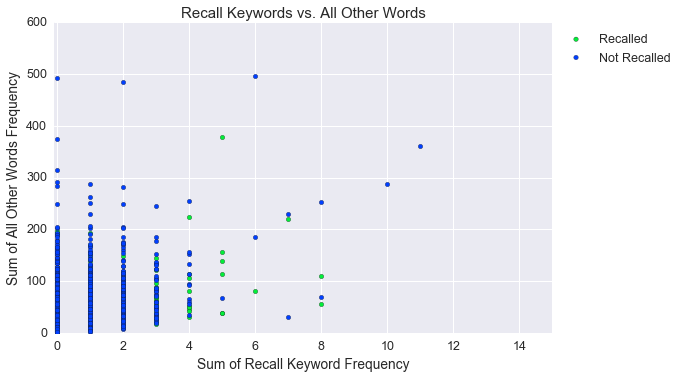

In [32]:
##Plot summation of features vs. classification
import scipy
from scipy.sparse import coo_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

vectorizer_excludeRecallkeywords = CountVectorizer(binary=False, ngram_range=(1, 1), stop_words=word_list)
food_review_text_sum = vectorizer_excludeRecallkeywords.fit_transform(final_text)
food_review_text_sum = scipy.sparse.coo_matrix.sum(food_review_text_sum, axis=1)
counts_recallwords = scipy.sparse.coo_matrix.sum(text_matrix2, axis=1)
df_for_graph = pd.concat([pd.DataFrame(counts_recallwords, columns=['recallWords']), \
                          pd.DataFrame(food_review_text_sum, columns=['otherWords']),\
                          pd.DataFrame(target, columns=['target'])], axis=1)


sns.set(style="darkgrid", color_codes=True, font_scale=1.25, palette='bright')
plt.xlim(-0.1,15)
plt.ylim(-0.1, 600)
plt.title('Recall Keywords vs. All Other Words')
plt.xlabel('Sum of Recall Keyword Frequency')
plt.ylabel('Sum of All Other Words Frequency')
plt.scatter(df_for_graph[df_for_graph.target==1].recallWords, df_for_graph[df_for_graph.target==1].otherWords,\
            marker='o', c='g', label='Recalled')
plt.scatter(df_for_graph[df_for_graph.target==0].recallWords, df_for_graph[df_for_graph.target==0].otherWords,\
            marker='o', c='b', label='Not Recalled')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [33]:
##Test model using cross validation 
from sklearn import cross_validation
target = np.array(Subset.recalled_1y)

scores = cross_validation.cross_val_score(model, text_matrix2, target, cv=50)
print("Mean Model Accuracy with 50 CV: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

text_matrix2test, text_matrix2train, Y_test, Y_train = train_test_split(text_matrix2, target, test_size=0.5, random_state=123)
model.fit(text_matrix2train, Y_train)
Y_pred = model.predict(text_matrix2test)
print("Precision: %1.3f" % precision_score(Y_test, Y_pred))
print("Recall: %1.3f" % recall_score(Y_test, Y_pred))
print("F1: %1.3f\n" % f1_score(Y_test, Y_pred))

Mean Model Accuracy with 50 CV: 0.83270 (+/- 0.01640)
Precision: 0.378
Recall: 0.025
F1: 0.047



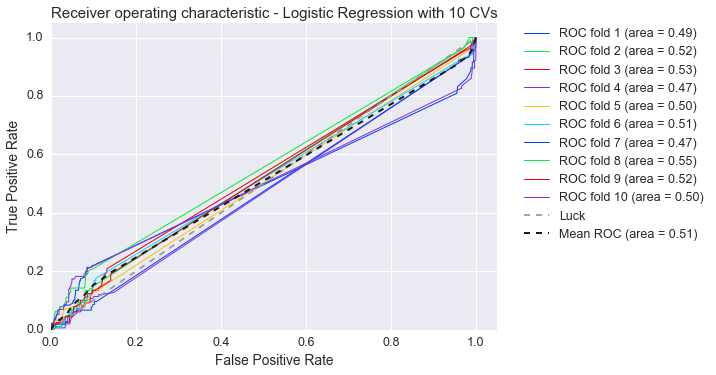

In [34]:
from sklearn.metrics import roc_curve, auc
from scipy import interp


sns.set(style="darkgrid", color_codes=True, font_scale=1.25, palette='bright')
###############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(lkf):
    probas_ = lr.fit(text_matrix2[train], target[train]).predict_proba(text_matrix2[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(lkf)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Logistic Regression with 10 CVs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Part 7 Non-linear Models

In [35]:
##Random Forest
from sklearn.ensemble import RandomForestClassifier
target = np.array(Subset.recalled_1y)

rfc = RandomForestClassifier(n_estimators=200, criterion='entropy')
nonlinear_results = rfc.fit(text_matrix, target)

In [37]:
##Statistics of the model
X_test, X_train, Y_test, Y_train = train_test_split(text_matrix, target, test_size=0.5, random_state=123)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print("\tAccuracy: %1.3f" % accuracy_score(Y_test, Y_pred))
print("\tPrecision: %1.3f" % precision_score(Y_test, Y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, Y_pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, Y_pred))

	Accuracy: 0.846
	Precision: 0.839
	Recall: 0.139
	F1: 0.239



In [36]:
##Find Important Terms
importance = np.transpose(nonlinear_results.feature_importances_)
importance_df = pd.DataFrame(importance, columns=['Importance'])
importance_df = pd.concat([term_names, importance_df], axis = 1)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df[importance_df.Importance > 0]

,Term,Importance
1832,coconut,1.673838e-02
7406,quino,1.133154e-02
9297,tea,9.989162e-03
1840,coff,7.950983e-03
7111,pouch,6.731438e-03
10269,wat,5.524771e-03
3895,good,5.077613e-03
9264,tast,5.049290e-03
7407,quinoa,5.019703e-03
5419,lov,4.986973e-03
